<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <h1 style="color:#00797C;padding-bottom:0px">Trend Modeling and Modeling with a Trend</h1>
    <h2 style="color:#00797C;padding-bottom:20px">A Companion Notebook to Geostatistics Lessons</h2>    
</div>

<p class="author" style="padding: 0;"><center><b>Sebastian Sanchez, Ben Harding and Ryan Barnett</b></center></p>
<p class="date" style="padding: 0;"><center><b>October 10, 2024</b></center></p>

---

# Outline

The following notebook accompanies the lesson [Trend Modeling and Modeling with a Trend](https://geostatisticslessons.com/lessons/trendmodeling). The following steps are used for demostrating the modern a approach for modeling in prescense of a trend, applying the same data from the lesson and applying minor refinements/additions.

1. **Load data**
    - Load and inspect data before defining a grid
1. **Normal score transformation and variography**
    - A normal score transform is not explicitly required prior to trend modeling, but generally improves behaviour of trend smoothing metrics, as well as Gaussian mixture model (GMM) fitting (used for trend removal)
    - Variography is performed on the normal scores to inform anisotropy of the moving window average (MWA) used for trend estimation
1. **Trend modeling**
    - Determine the optimal MWA smoothing parameters before estimating the normal scores trend over the grid
1. **Detrending transformation and variography**
    - Remove the trend from the normal scores using a stepwise conditional transformation with GMM parameterization
    - Variography is performed on the detrended variable to parameterize the continuity that is input to simulation
1. **Simulation**
    - Simulate the detrended variable before visualizing the results
1. **Back-transform**
    - Simulate the detrended variable before visualizing the results
1. **Checking**
    - Check the realizations for reproduction of the histogram, variogram, trend and visual characteristics

Although executed on a small 2D dataset for ease of understanding, the presented workflow may be extended/adapted to represent other deposits.

---

Import required packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rmsp

Activate RMSP and setup some global parameters:

In [2]:
rmsp.activate()
log_progress = False  # Set to true for progressbars on intensive tasks
rmsp.GlobalParams["core.log_progress"] = log_progress
rmsp.GlobalParams["core.enable_beta"] = True
rmsp.GlobalParams["plotting.grid"] = True

License cleq45ynp00hggomxzudtanh0 checked out by jared@resmodsol.com to cm23imup30runcx6f90iokmsn expires in 51 minutes. RMSP is up to date!


Setup some coloring/naming parameters:

In [3]:
var = rmsp.Variable('Value').set_variable_params(
    clim=(0.9, 3.6), cmap='viridis')
ns_var = rmsp.Variable("NS_" + var.col).set_variable_params(
    clim=(-2, 2), axis_lim=(-3, 3), cmap='Spectral_r')
dt_var = ns_var.clone("DT_" + var.col)

---

# Load Data

Load example data that was used in the Lesson:

In [4]:
samples = rmsp.PointData(pd.read_csv("samples.csv"), x="X", y="Y")
samples.head()

,X,Y,wts,Value
0,4.498,6.141,0.98,1.209
1,29.803,3.799,0.90,1.511
2,50.928,5.057,0.84,1.861
3,73.395,5.370,0.90,2.531
4,93.624,3.186,0.94,2.075


Visualize the samples values and declustering weights. For more information about declustering, please take a look at the lesson [Cell Declustering Parameter Selection](https://geostatisticslessons.com/lessons/celldeclustering), although nearest neighbour or inverse distance are often preferred for capturing the geometry of domains to be simulated, and/or appropriately managing soft boundaries.

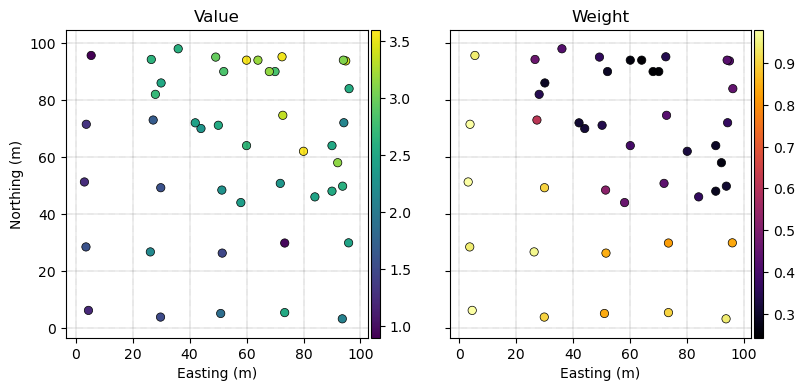

In [5]:
fig, axes = rmsp.ImageGrid(1, 2, figsize=(9, 4), cbar_mode="each", axes_pad=(0.7, 0.4))
samples.sectionplot(var.col, ax=axes[0], ec="k")
samples.sectionplot('wts', ax=axes[1], ec="k", cmap="inferno", title='Weight')

Define a grid for trend modeling and simulation, matching the grid used in the lesson:

In [6]:
griddef = rmsp.GridDef(
    usize=1.0, vsize=1.0, zsize=1.0,
    xcmin=0.5, ycmin=0.5, zcmin=0.5,
    nu=100, nv=100, nz=1, blockindices='full'
)
grid = rmsp.GridData(griddef=griddef)
griddef.to_table()

,Easting,Northing
minimum (m),0.0,0.0
maximum (m),100.0,100.0
size (m),1.0,1.0
number,100,100


---
# Normal Score Transformation and Variography

## Transformation
The details of the normal score transformation can be found in the lesson [Transforming Data to a Gaussian Distribution](https://geostatisticslessons.com/lessons/normalscore). Normal score transformation is a necessary prerequisite step to the trend modeling and modeling with a trend workflow.

Apply normal score transform:

In [7]:
nscore = rmsp.NSTransformer()
samples[ns_var.col] = nscore.fit_transform(samples[var.col], samples['wts'])

## Variography

Experimental variogram calculation and modeling: The lag parameters (spacing, tolerance and number of lags) are defined for experimental variograms calculation. The searches are defined using the lags and specified major/minor directions that are understood in this instance. Variography is wrapped in a function to permit re-use in detrended units.

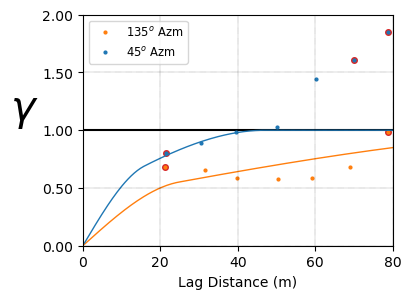

In [8]:
major, minor = 135, 45


def calc_model_varios(var, xlim=(0, 80), ylim=(0, 1.2), azmtol=25, num_struct=3, plot=True):
    # Experimental
    lags = [rmsp.Lags(5, 5, 2), rmsp.Lags(10, 7.5, 10)]
    searches = [rmsp.ExpVarioSearch(azm, 0.0, lags, azmtol=azmtol)
                for azm in [major, minor]]
    expvario = rmsp.ExpVario().calculate(samples, var, searches)
    # Model
    variomodel = rmsp.VarioModel.fit_experimental(
        expvario, num_struct=num_struct,
        nugget=0.0, shapes=["spherical"] * num_struct,
        angle1=[major] * num_struct, angle2=[0.0] * num_struct, angle3=[0.0] * num_struct,
        range1=[[20, 500]] * num_struct, ranges12_bounds=[[1.5, 4]] * num_struct)
    # Plot
    if plot:
        fig, ax = variomodel.plot(azm=major, incl=0.0, c="C1", xlim=xlim, ylim=ylim, figsize=(4, 3))
        expvario.plot_draw(ax=ax, azm=major, c="C1", label=f"{major}$^o$ Azm")
        variomodel.plot_draw(ax=ax, azm=minor, incl=0.0, c="C0")
        expvario.plot_draw(ax=ax, azm=minor, c="C0", label=f"{minor}$^o$ Azm")
        _ = ax.legend(fontsize="small")
    return expvario, variomodel

expvario, variomodel = calc_model_varios(ns_var.col, ylim=(0, 2.0))

---

# Trend Modeling

The search from trend modeling is obtained by buffering the variogram model. Search is based on the square root of anisotropy, following Qu (2018) recommendations:

In [9]:
trend_search = rmsp.Search.from_vario_buffer(
    variomodel,
    buffer_by=100,
    min_comps=1,
    scale_aniso="sqrt",
)

Select number of composites by testing differente number of max composites and plotting against the trend-residual correlation. The composite number at the minimun trend-residual correlation is scaled using a factor of 2.0 following Qu (2018), although that criteria is sometimes found to oversmooth (or undersmooth) in practice, so careful visual inspection is always recommended, adjusting from its baseline guidance if needed.

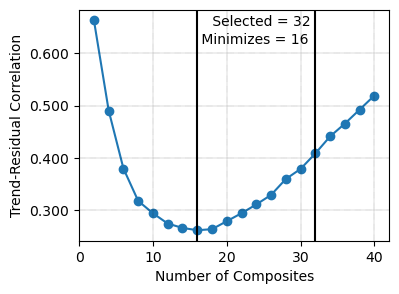

In [10]:
trend_est = rmsp.TrendEstimator(trend_search, sum_to_unity=False)
trend_est.minimize_residual_corr(
    samples, ns_var.col, scale_factor=2.0, test_min=2, test_max=40, test_inc=2
)
fig, ax = trend_est.plot_residual_corr(figsize=(4, 3), xlim=(0, 42))

Estimate trend across the grid:

In [11]:
trend = trend_est.estimate(grid, samples, ns_var.col)

Visualize trend:

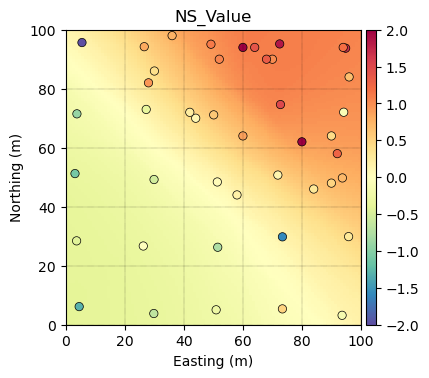

In [12]:
fig, ax, cax = trend.sectionplot(
    ns_var.col, figsize=(4, 4))
_ = samples.sectionplot_draw(ax=ax, var=ns_var.col, ec="k")

---
# Detrending Transformation and Variography

## Transformation
The RMSP function `TrendTransformer` does all the neccesary steps for detrending:

1. Extract trend values at data locations 
1. Fit GMM to the bivariate variable-trend relationship
1. GMM-SCT decorrelation of the bivariate variable-trend relationship to produce residuals that are assumed to be first-order stationary

These steps are achieved with the following `fit` and `transform` calls.

**Note** that the `fit_exhaustive` may struggle to converge with larger grids (e.g., >1M) - consider setting `fit_exhaustive` to False and providing declustering `weights` in those cases.

In [13]:
trend_transformer = rmsp.TrendTransformer(fit_exhaustive=True)
trend_transformer.fit(
    trend,
    samples,
    ns_var.col,
    num_kernels=2
)

samples[dt_var.col] = trend_transformer.transform(trend, samples, ns_var.col)

Visualize the relationship and fit GMM:

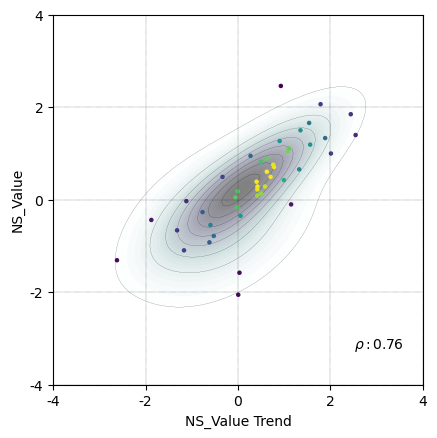

In [14]:
_ = trend_transformer.bivplots(trend, samples, scatplot_kws={"s": 5})

Visualize residuals and trend correlation after de-trending:

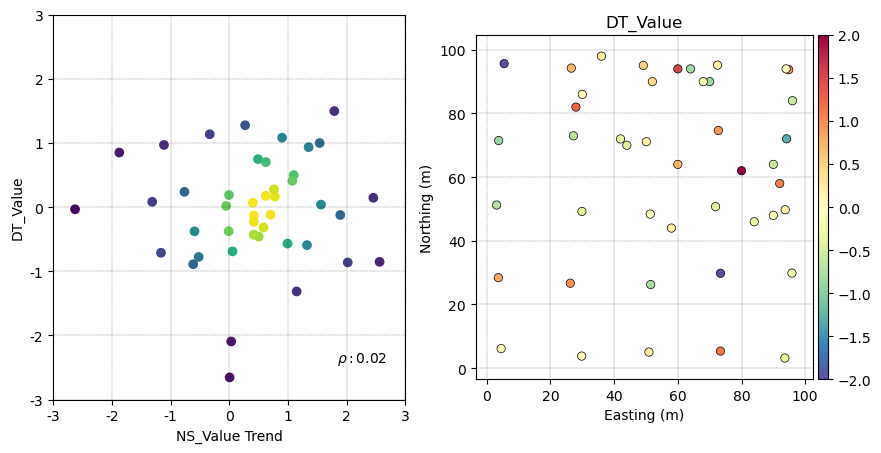

In [15]:
dt_var.clone(f"{dt_var} Trend")
samples[f"{ns_var} Trend"] = trend_transformer.get_transformed_trend(ns_var.col, samples)[f"{ns_var} trend"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = samples.scatplot(
    f"{dt_var} Trend",
    dt_var.col,
    wt='wts',
    ax=axes[0]
)
samples.sectionplot(dt_var.col, ec="k", ax=axes[1])

## Variography
De-trended values variography. An omni-directional variograms is calculated and modeled, as the extreme sparsity that is present (in this case), intersects with the reduced continuity (always expected with detrending) to yield insufficient stability with directional variograms. In practice, one may prefer to enforce muted anisotropy, as detrending is expected to reduce but not removed anisotropy that is observed in original or detrended units.

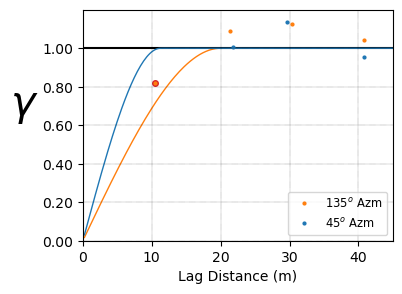

In [16]:
dt_variomodel = calc_model_varios(dt_var.col, xlim=(0, 45), azmtol=50, num_struct=1)[1]

---

# Simulation

The number of realizations to simulate:

In [17]:
num_real = 100

Conditional simulation is performed below. Notice that the variograms used in the simulation come from the detrended residuals:

In [18]:
simcache = rmsp.Simulator().simulate(
    grid,
    samples,
    dt_var.col,
    rmsp.Search.from_vario_buffer(dt_variomodel, max_comps=30),
    dt_variomodel,
    reals=num_real,
    seed=9897154,
    cache=f"./simcache/",
    cache_var=dt_var.col,
)

Visualize some realizations of the detrended variable. Wrap in a function to visualize after each back-transform.

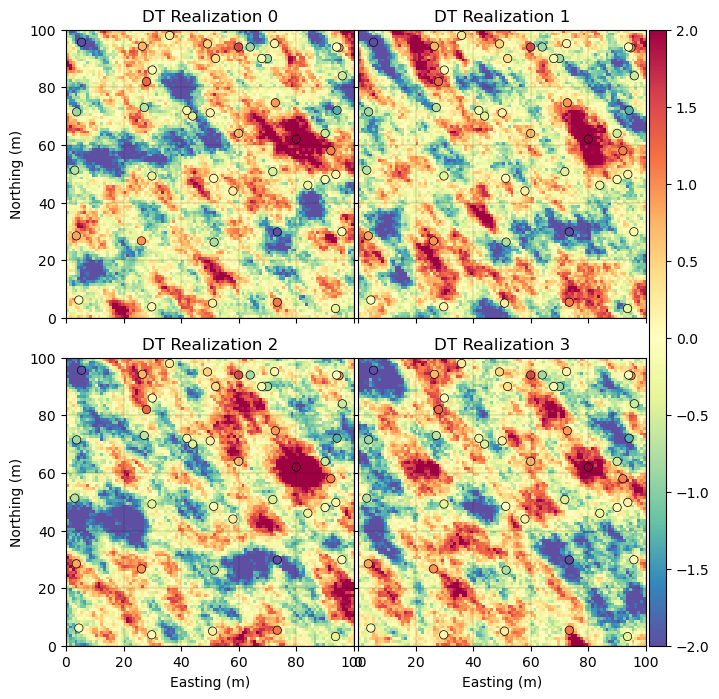

In [19]:
def plot_realizations(simcache, var, title_prefix=""):
    """Plots the first 4 realizations"""
    fig, axes = rmsp.ImageGrid(2, 2, (8, 8), cbar_mode="single")
    for i, real in simcache.iter_realizations(reals=4, griddef=griddef):
        real.sectionplot(var, ax=axes[i], title=f"{title_prefix} Realization {i}")
        samples.sectionplot_draw(ax=axes[i], var=var, ec="k")

plot_realizations(simcache, dt_var.col, "DT")

---

# Back-transform

Re-introduce the trend to the realizations:

In [20]:
ns_cache = trend_transformer.inverse_transform_sim(simcache, dt_var.col, "./simcache/", ns_var.col)

Visualize some realizations of the normal scores:

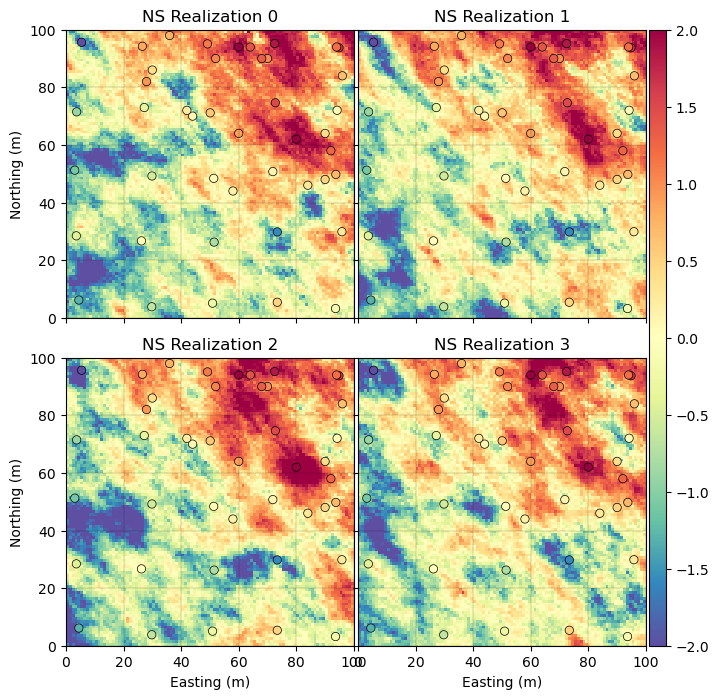

In [21]:
plot_realizations(ns_cache, ns_var.col, "NS")

Invert the Gaussian transformation to original units:

In [22]:
cache = nscore.inverse_transform_sim(ns_cache, ns_var.col, "./simcache/", var.col)

Visualize some realizations of the original variable:

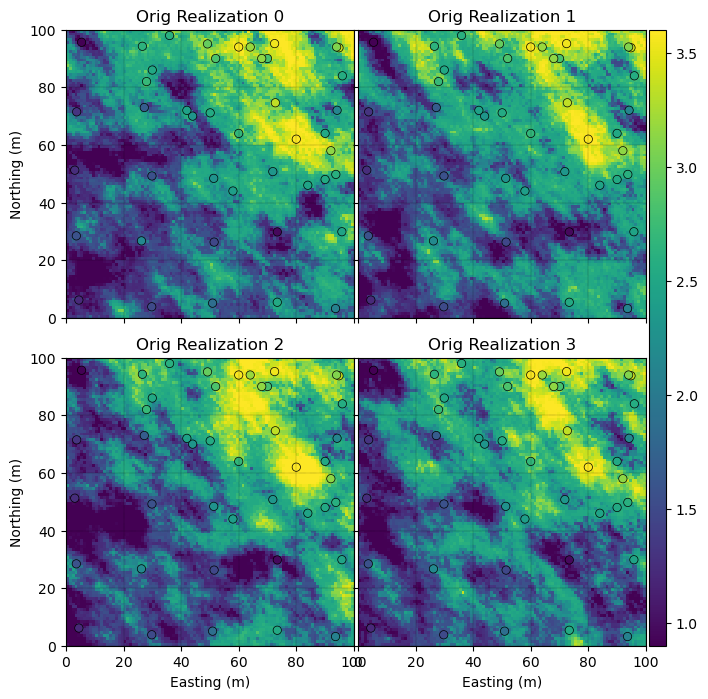

In [23]:
plot_realizations(cache, var.col, 'Orig')

---

# Checking

Distribution checking:

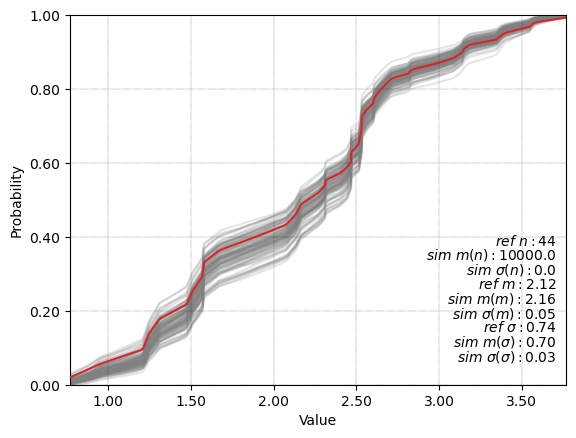

In [24]:
sim_unistats = [rmsp.UniStats(real[var.col])
                for _, real in cache.iter_realizations()]
refstats = rmsp.UniStats(samples[var.col], samples['wts'])
fig, ax = refstats.cdfplot_checkreals(sim_unistats, xlabel=var.col, mod_alpha=0.2)

Calculate the variogram of the realizations and the data in original units before comparing.

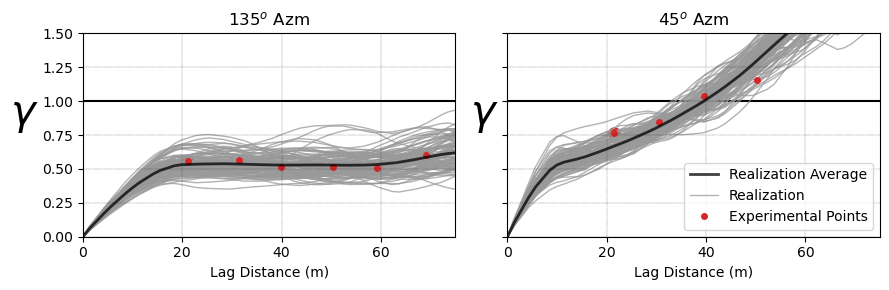

In [25]:
expvario0 = calc_model_varios(var.col, plot=False)[0]
grid_searches = [rmsp.ExpVarioSearchGrid(major, 0.0, 2.0 * np.arange(50)),
                 rmsp.ExpVarioSearchGrid(minor, 0.0, 2.0 * np.arange(75))]
grid_expvario = rmsp.ExpVario().calculate_sim(cache, var.col, grid_searches, griddef, permit_standardized=True)

fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
for i, (ax, azm) in enumerate(zip(axes, [major, minor])):
    grid_expvario.plot_reals(
        i, title=f"{azm}$^o$ Azm", ax=ax, xlim=(0, 75), ylim=(0, 1.5), alpha=0.75)
    expvario0.plot_draw(ax, azm=azm, ms=4, label="Experimental Points", c="C3")

axes[1].legend(loc=4)
plt.tight_layout()

Although trends are visually reproduced, check swath plot reproduction to ensure:

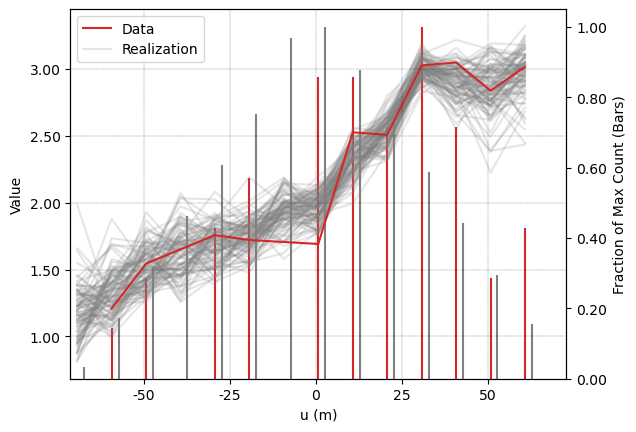

In [26]:
# Data swath
swath = rmsp.Swath(orient=minor, width=10)
swath.fit(samples, var.col)
fig, ax = swath.plot(c='C3', swath_label='Data')

# Realization swath
real = cache.get_real(0, griddef=griddef)
swath.fit(real, save_indices=True)
swath_kws = dict(c='.5', swath_kws={'alpha': .2, 'zorder': -1})
swath.plot_draw(ax, swath_label='Realization', count_xoffset=2.0, **swath_kws)

# Remaining realizations
for ireal, real in cache.iter_realizations(griddef=griddef, reals=np.arange(1, num_real)):
    swath.clone_on(real, use_indices=True).plot_draw(ax, count_lw=0, **swath_kws)

_ = ax.legend()

---
# Closing Comments

This notebook provided a worked example of key concepts introduced in [Trend Modeling and Modeling with a Trend](https://geostatisticslessons.com/lessons/trendmodeling), including:

- Modeling of a trend including optimization of smoothing
- Removal of a trend using stepwise conditional transformation with Gaussian mixture model parameterization
- Checking simulated realizations for reproduction of key representative properties, including non-stationarity
    
An important consideration for the holistic characterization of uncertainty, may be the parameterization and integration of trend uncertainty, which may be covered in a future lesson or companion notebook.

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>